In [1]:
import pm4py
log_all = pm4py.read_xes('BPIChallenge2017.xes.gz')

c:\Users\Mara Tews\Documents\Uni\RWTH_DataScience\SS_2022\SS2022_ProcessDiscoveryUsingPython\eXdpn\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 31509/31509 [03:08<00:00, 167.06it/s]


In [2]:
print(f'activities: {list(pm4py.get_event_attribute_values(log_all,"concept:name").keys())}')

activities: ['A_Create Application', 'A_Submitted', 'W_Handle leads', 'W_Complete application', 'A_Concept', 'A_Accepted', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'W_Call after offers', 'A_Complete', 'W_Validate application', 'A_Validating', 'O_Returned', 'W_Call incomplete files', 'A_Incomplete', 'O_Accepted', 'A_Pending', 'A_Denied', 'O_Refused', 'O_Cancelled', 'A_Cancelled', 'O_Sent (online only)', 'W_Assess potential fraud', 'W_Personal Loan collection', 'W_Shortened completion ']


In [3]:
# We only look at subtraces of activities starting with an 'O'.
# Semantically, this means we look at the events corresponding to
# the offer of a trace.
log = pm4py.filter_event_attribute_values(
    log_all,
    "concept:name",
    ['O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'O_Returned',
     'O_Accepted', 'O_Cancelled', 'O_Refused', 'O_Sent (online only)'],
    level="event",
    retain=True)

print("Number of different trace variants - subtraces: ", len(pm4py.get_variants_as_tuples(log)))

filtered_log = pm4py.filter_variants(log, [
    ('O_Create Offer', 'O_Created',
     'O_Sent (mail and online)', 'O_Returned', 'O_Accepted'),
    ('O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'O_Refused'),
    ('O_Create Offer', 'O_Created',
     'O_Sent (mail and online)', 'O_Returned', 'O_Cancelled'),
    ('O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'O_Cancelled'),
    ('O_Create Offer', 'O_Created',
     'O_Sent (mail and online)', 'O_Returned', 'O_Refused'),
    ('O_Create Offer', 'O_Created', 'O_Sent (online only)', 'O_Returned', 'O_Accepted'),
    ('O_Create Offer', 'O_Created', 'O_Sent (online only)', 'O_Refused'),
    ('O_Create Offer', 'O_Created',
     'O_Sent (online only)', 'O_Returned', 'O_Cancelled'),
    ('O_Create Offer', 'O_Created', 'O_Sent (online only)', 'O_Cancelled'),
    ('O_Create Offer', 'O_Created', 'O_Sent (online only)', 'O_Returned', 'O_Refused')])

print("Number of different trace variants - filtered subtraces: ", len(pm4py.get_variants_as_tuples(filtered_log)))

pm4py.write_xes(filtered_log, "BPIChallenge2017_filtered.xes")


Number of different trace variants - subtraces:  877
Number of different trace variants - filtered subtraces:  10


exporting log, completed traces :: 100%|██████████| 22771/22771 [00:20<00:00, 1118.53it/s]


In [4]:
# We discard less frequent variants in order to reduce
# the number of edge cases
#log_top_200 = pm4py.filter_variants_top_k(filtered_log, 1000)
#print(""Number of different trace variants - filtered subtraces top k:", len(pm4py.get_variants_as_tuples(log_top_200)))
#pm4py.write_xes(log_top_200, "BPIChallenge2017_filtered_top_k.xes")

### Analysis

In [1]:
import pm4py
log = pm4py.read_xes('BPIChallenge2017_filtered.xes')

c:\Users\Mara Tews\Documents\Uni\RWTH_DataScience\SS_2022\SS2022_ProcessDiscoveryUsingPython\eXdpn\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 22771/22771 [00:22<00:00, 1030.33it/s]


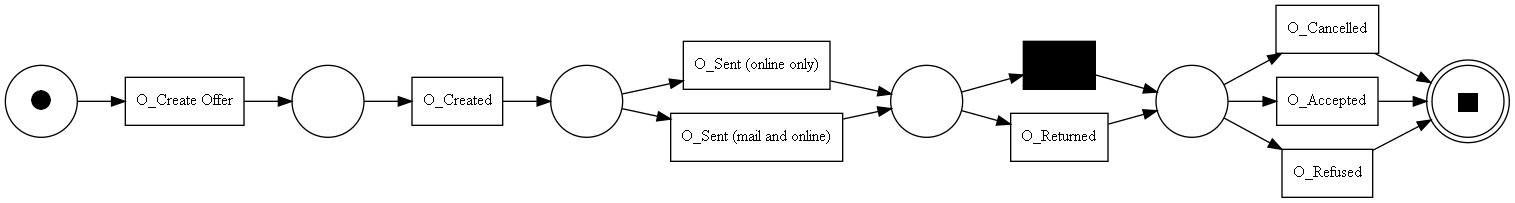

In [2]:
from exdpn.petri_net import get_petri_net

net, im, fm = get_petri_net(log, miner_type='IM')
pm4py.view_petri_net(net, im, fm)

As we can see, we have three decision points in our log / the corresponding Petri net.
We now take all trace-level and event-level attributes that do not have ID-esque semantics:

In [3]:
trace_attrs = list(pm4py.get_trace_attributes(log))
trace_attrs 

['ApplicationType', 'LoanGoal', 'RequestedAmount']

In [4]:
event_attrs = list(pm4py.get_event_attributes(log))
event_attrs = [attr for attr in event_attrs if max(list(pm4py.get_event_attribute_values(log, attr).values())) != 1 and "ID" not in attr]
event_attrs.remove("time:timestamp")
event_attrs.remove("org:resource")
event_attrs

['OfferedAmount',
 'Selected',
 'NumberOfTerms',
 'CreditScore',
 'FirstWithdrawalAmount',
 'MonthlyCost',
 'Accepted',
 'Action',
 'EventOrigin',
 'concept:name']

We now initialize our data Petri net with all techniques and provide no hyperparameters to the models.
This means that standard hyperparameters from e.g. scikit-learn will be used to instantiate the concrete classifiers.
We also use exdpn's feature to impute missing data.

In [18]:
from exdpn.data_petri_net import Data_Petri_Net
from exdpn.guards import ML_Technique

ml_list = [ML_Technique.DT, 
ML_Technique.LR, 
ML_Technique.RF, 
ML_Technique.SVM, 
ML_Technique.NN, 
ML_Technique.XGB]

dpn = Data_Petri_Net(log, petri_net=net, initial_marking=im, final_marking=fm,
                     event_level_attributes=event_attrs,
                     case_level_attributes=trace_attrs,
                     ml_list=ml_list, 
                     verbose=True, 
                     impute=True, 
                     hyperparameters={ML_Technique.DT: {},
                                      ML_Technique.NN: {},
                                      ML_Technique.LR: {},
                                      ML_Technique.SVM: {},
                                      ML_Technique.RF: {},
                                      ML_Technique.XGB: {}})

-> Mining guard datasets... Done
-> Evaluating guards at decision point 'p_4'... 

Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.


Done
-> Evaluating guards at decision point 'p_6'... 

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Liblinear failed to converge, increase the number of iterations.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Liblinear failed to converge, increase the number of iterations.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (ma

Done
-> Evaluating guards at decision point 'p_5'... 

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Liblinear failed to converge, increase the number of iterations.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of

Done


In [19]:
best = dpn.get_best()

-> Best machine learning technique at decision point 'p_4': Logistic Regression w/ performance 0.9819215369713399
-> Best machine learning technique at decision point 'p_6': XGBoost w/ performance 0.7967064573735645
-> Best machine learning technique at decision point 'p_5': Random Forest w/ performance 0.5725723760950334


In [20]:
import pandas as pd

res = pd.DataFrame(columns=["place"] + [str(ml_t for ml_t in ml_list)])

for dp,gm in dpn.guard_manager_per_place.items():
    res_row = {"place": dp} | {str(ml_t):gm.f1_mean_test[ml_t] for ml_t in gm.guards_list.keys()}
    res = res.append([res_row])
    
res['place'] = res['place'].apply(str)
res.index = res["place"]
res.drop(["place"], axis=1, inplace=True)
res.dropna(axis=1, how="all", inplace=True)

In [21]:
res.transpose()

place,p_4,p_6,p_5
Decision Tree,0.981570,0.794316,0.569212
Logistic Regression,0.981922,0.796275,0.550063
Random Forest,0.981614,0.793752,0.572572
Support Vector Machine,0.981922,0.796275,0.550268
Neural Network,0.981922,0.796238,0.553858
XGBoost,0.981900,0.796706,0.561575


In [22]:
#import seaborn as sns

#sns.heatmap(res.transpose(), annot=True, cmap="PiYG", center=0.7)

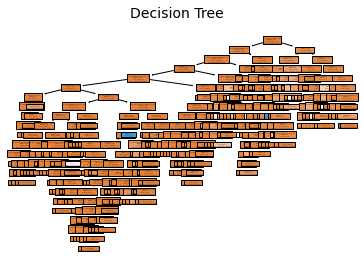

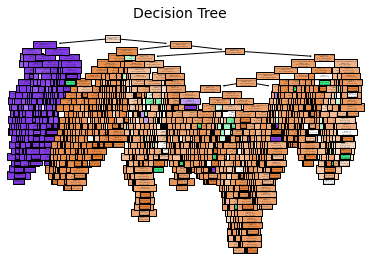

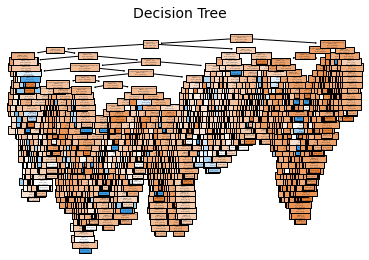

In [23]:
dps = list(dpn.decision_points)
for p in dps:
    dt_guard = dpn.guard_manager_per_place[p].guards_list[ML_Technique.DT]
    dt_explainable_representation = dt_guard.get_explainable_representation()

With hyperparameter:

In [62]:
from exdpn.data_petri_net import Data_Petri_Net
from exdpn.guards import ML_Technique

ml_list = [ML_Technique.DT, ML_Technique.LR, ML_Technique.NN, ML_Technique.SVM, ML_Technique.RF, ML_Technique.XGB]

dpn_hp = Data_Petri_Net(log, petri_net=net, initial_marking=im, final_marking=fm,
                     event_level_attributes=event_attrs,
                     case_level_attributes=trace_attrs,
                     ml_list=ml_list, 
                     verbose=True, 
                     #impute=True,
                     CV_splits = 5,
                     hyperparameters = {ML_Technique.NN: {'hidden_layer_sizes': (5, 5)}, 
                                        ML_Technique.DT: {'ccp_alpha': 0.003},
                                        ML_Technique.LR: {"C": 0.1},
                                        ML_Technique.SVM: {"C": 0.1},
                                        ML_Technique.XGB: {"max_depth": 3},
                                        ML_Technique.RF: {'n_estimators': 100,
                                                          'ccp_alpha': 0.003}})

-> Mining guard datasets... Done
-> Evaluating guards at decision point 'p_4'... 

Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.


Done
-> Evaluating guards at decision point 'p_6'... 

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Liblinear failed to converge, increase the number of iterations.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Liblinear failed to converge, increase the number of iterations.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (ma

Done
-> Evaluating guards at decision point 'p_5'... 

Liblinear failed to converge, increase the number of iterations.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Liblinear failed to converge, increase the number of it

Done


In [63]:
best_hp = dpn_hp.get_best()

-> Best machine learning technique at decision point 'p_4': Decision Tree w/ performance 0.9819215369713399
-> Best machine learning technique at decision point 'p_6': XGBoost w/ performance 0.7963550121041679
-> Best machine learning technique at decision point 'p_5': XGBoost w/ performance 0.5537695530461967


In [64]:
import pandas as pd 

res_hp = pd.DataFrame(columns=["place"] + [str(ml_t for ml_t in ml_list)])

for dp,gm in dpn_hp.guard_manager_per_place.items():
    res_row = {"place": dp} | {str(ml_t):gm.f1_mean_test[ml_t] for ml_t in gm.guards_list.keys()}
    res_hp = res_hp.append([res_row])

res_hp['place'] = res_hp['place'].apply(str)
res_hp.index = res_hp["place"]
res_hp.drop(["place"], axis=1, inplace=True)
res_hp.dropna(axis=1, how="all", inplace=True)

res_hp.transpose()

place,p_4,p_6,p_5
Decision Tree,0.981922,0.796319,0.550063
Logistic Regression,0.981922,0.796319,0.550063
Neural Network,0.981922,0.796297,0.550734
Support Vector Machine,0.981922,0.796319,0.550063
Random Forest,0.981922,0.796319,0.550063
XGBoost,0.981922,0.796355,0.553770


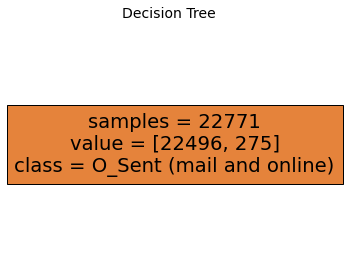

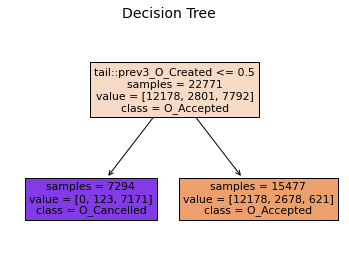

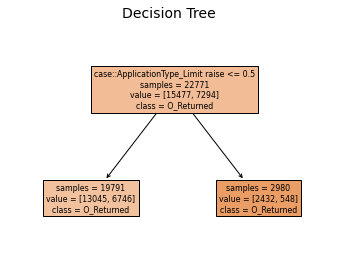

In [27]:
dps_hp = list(dpn_hp.decision_points)
for p in dps_hp:
    dt_guard = dpn_hp.guard_manager_per_place[p].guards_list[ML_Technique.DT]
    dt_explainable_representation = dt_guard.get_explainable_representation()

#### Summary:
DT without hyperparameters not explainable, with hyperparameters its better. Performances same for all three decision points. 

In [28]:
res.transpose()

place,p_4,p_6,p_5
Decision Tree,0.981570,0.794316,0.569212
Logistic Regression,0.981922,0.796275,0.550063
Random Forest,0.981614,0.793752,0.572572
Support Vector Machine,0.981922,0.796275,0.550268
Neural Network,0.981922,0.796238,0.553858
XGBoost,0.981900,0.796706,0.561575


In [29]:
res_hp.transpose()

place,p_4,p_6,p_5
Decision Tree,0.981922,0.796319,0.550063
Logistic Regression,0.981922,0.796319,0.550063
Neural Network,0.981922,0.796099,0.551099
Support Vector Machine,0.981922,0.796319,0.550063
Random Forest,0.981922,0.796319,0.550063
XGBoost,0.981922,0.796355,0.553770


### Appendix: Insights to selected hyperparameters

#### Optimize DT hyperparameters with respect to explainablitiy:

In [30]:
from exdpn.data_petri_net import Data_Petri_Net
from exdpn.guards import ML_Technique

dt_hp = [{ML_Technique.DT: {}}, 
         {ML_Technique.DT: {'ccp_alpha': 0.00005}},
         {ML_Technique.DT: {'ccp_alpha': 0.001}},
         {ML_Technique.DT: {'ccp_alpha': 0.002}},
         {ML_Technique.DT: {'ccp_alpha': 0.003}}] 

dps_dt = list(dpn_hp.decision_points)
print(dps_dt)

[p_4, p_6, p_5]


p_4


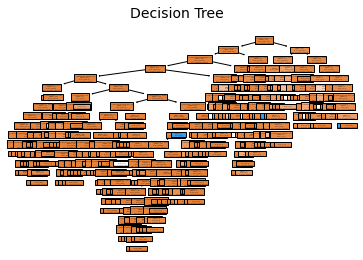

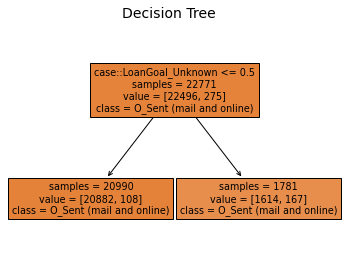

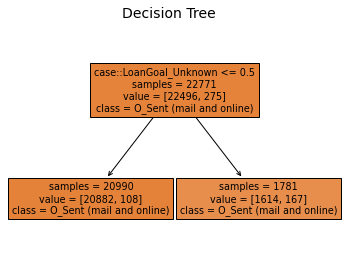

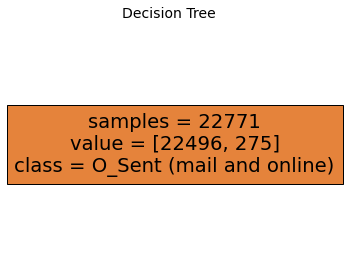

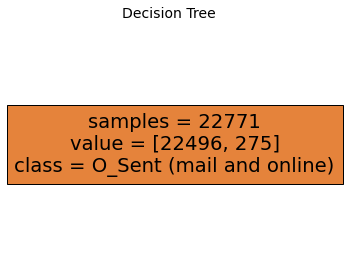

In [31]:
dps_temp = dps_dt[0]
print(dps_temp)
dt_hp_scores = []

for hp in dt_hp: 
    dpn_temp = Data_Petri_Net(log, petri_net=net, initial_marking=im, final_marking=fm,
                              event_level_attributes=event_attrs,
                              case_level_attributes=trace_attrs,
                              ml_list=[ML_Technique.DT], 
                              verbose=False, 
                              impute=True,
                              hyperparameters = hp)


    dt_guard = dpn_temp.guard_manager_per_place[dps_temp].guards_list[ML_Technique.DT]
    dt_hp_scores.append([dpn_temp.guard_manager_per_place[dps_temp].f1_mean_test])
    rep = dt_guard.get_explainable_representation()

In [32]:
dt_hp_scores

[[{<ML_Technique.DT: <class 'exdpn.guards.decision_tree_guard.Decision_Tree_Guard'>>: 0.981570055026315}],
 [{<ML_Technique.DT: <class 'exdpn.guards.decision_tree_guard.Decision_Tree_Guard'>>: 0.9819215369713399}],
 [{<ML_Technique.DT: <class 'exdpn.guards.decision_tree_guard.Decision_Tree_Guard'>>: 0.9819215369713399}],
 [{<ML_Technique.DT: <class 'exdpn.guards.decision_tree_guard.Decision_Tree_Guard'>>: 0.9819215369713399}],
 [{<ML_Technique.DT: <class 'exdpn.guards.decision_tree_guard.Decision_Tree_Guard'>>: 0.9819215369713399}]]

p_6


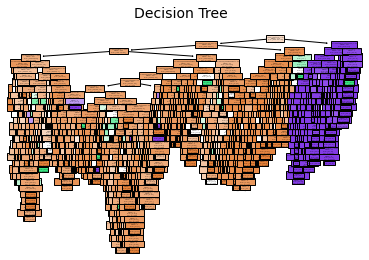

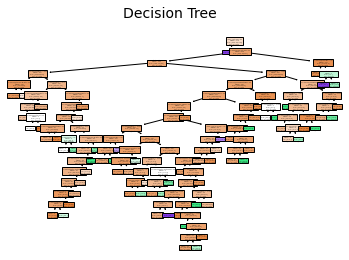

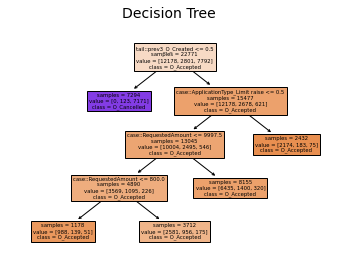

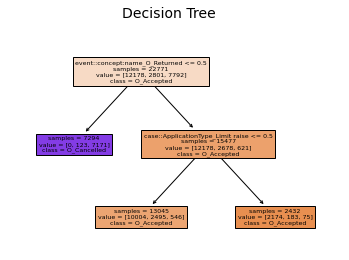

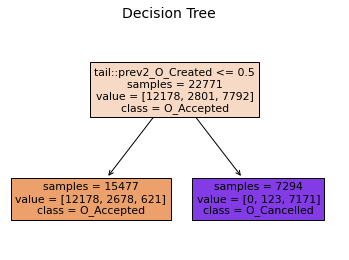

In [33]:
dps_temp = dps_dt[1]
print(dps_temp)
dt_hp_scores = []

for hp in dt_hp: 
    dpn_temp = Data_Petri_Net(log, petri_net=net, initial_marking=im, final_marking=fm,
                              event_level_attributes=event_attrs,
                              case_level_attributes=trace_attrs,
                              ml_list=[ML_Technique.DT], 
                              verbose=False, 
                              impute=True,
                              hyperparameters = hp)


    dt_guard = dpn_temp.guard_manager_per_place[dps_temp].guards_list[ML_Technique.DT]
    dt_hp_scores.append([dpn_temp.guard_manager_per_place[dps_temp].f1_mean_test])
    rep = dt_guard.get_explainable_representation()

In [34]:
dt_hp_scores

[[{<ML_Technique.DT: <class 'exdpn.guards.decision_tree_guard.Decision_Tree_Guard'>>: 0.7942256493927431}],
 [{<ML_Technique.DT: <class 'exdpn.guards.decision_tree_guard.Decision_Tree_Guard'>>: 0.7964565042142981}],
 [{<ML_Technique.DT: <class 'exdpn.guards.decision_tree_guard.Decision_Tree_Guard'>>: 0.7963187718805501}],
 [{<ML_Technique.DT: <class 'exdpn.guards.decision_tree_guard.Decision_Tree_Guard'>>: 0.7963187718805501}],
 [{<ML_Technique.DT: <class 'exdpn.guards.decision_tree_guard.Decision_Tree_Guard'>>: 0.7963187718805501}]]

p_5


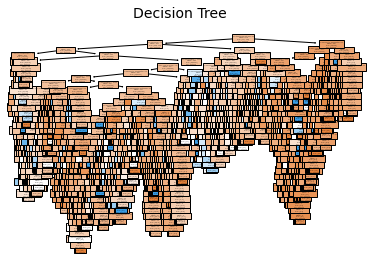

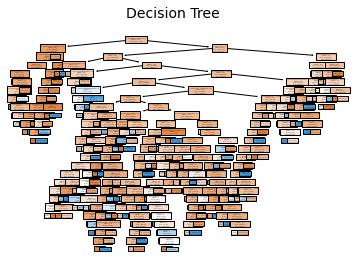

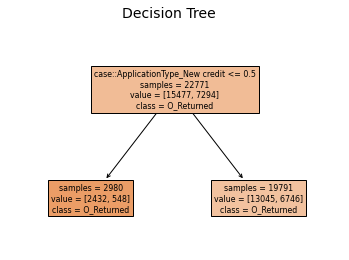

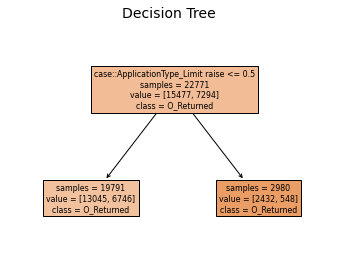

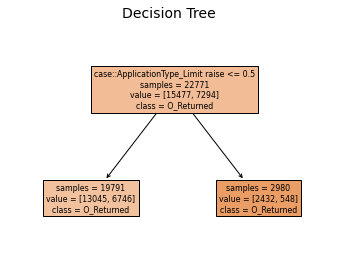

In [35]:
dps_temp = dps_dt[2]
print(dps_temp)
dt_hp_scores = []

for hp in dt_hp: 
    dpn_temp = Data_Petri_Net(log, petri_net=net, initial_marking=im, final_marking=fm,
                              event_level_attributes=event_attrs,
                              case_level_attributes=trace_attrs,
                              ml_list=[ML_Technique.DT], 
                              verbose=False, 
                              impute=True,
                              hyperparameters = hp)


    dt_guard = dpn_temp.guard_manager_per_place[dps_temp].guards_list[ML_Technique.DT]
    dt_hp_scores.append([dpn_temp.guard_manager_per_place[dps_temp].f1_mean_test])
    rep = dt_guard.get_explainable_representation()

#### Cross-Validation Neural Network

In [5]:
import numpy as np 
from exdpn.petri_net import get_petri_net
from exdpn.guard_datasets import extract_all_datasets
from exdpn.data_preprocessing import basic_data_preprocessing
from sklearn.model_selection import RandomizedSearchCV
from exdpn.data_preprocessing.data_preprocessing import apply_ohe, apply_scaling, fit_scaling, fit_ohe

# prepare data
dp_dataset_map = extract_all_datasets(log= log, net=net, initial_marking=im, final_marking=fm, 
                                      event_level_attributes = event_attrs,
                                      case_level_attributes=trace_attrs)

# decision points 
dps = list(dp_dataset_map.keys())
print(dps)

[p_5, p_4, p_6]


In [59]:
from sklearn.neural_network import MLPClassifier

# hyperparameters to be tuned
hidden_layer_sizes = [(5, ), (5, 5), (10, 10), (5, 10, 5), (10, 20, 10)]
# search grid
nn_params = {'hidden_layer_sizes': hidden_layer_sizes}
print(nn_params)

{'hidden_layer_sizes': [(5,), (5, 5), (10, 10), (5, 10, 5), (10, 20, 10)]}


In [61]:
for dp in dps:
    print(dp)
    dp_dataset = dp_dataset_map[dp]
    X_train, y_train = basic_data_preprocessing(dp_dataset)
    scaler, scaler_columns = fit_scaling(X_train)
    X_train = apply_scaling(X_train, scaler, scaler_columns)
    ohe = fit_ohe(X_train)
    X_train = apply_ohe(X_train, ohe)
    transition_int_map = {transition: index for index,
                          transition in enumerate(list(set(y_train)))}
    y_train_mapped = [transition_int_map[transition] for transition in y_train]

    # model to be tuned
    nn_base = MLPClassifier()
    nn_random = RandomizedSearchCV(estimator = nn_base, 
                                   param_distributions = nn_params, 
                                   n_iter = 5, 
                                   cv = 3, 
                                   verbose = 2, 
                                   random_state = 42, 
                                   n_jobs = -1)

    nn_random.fit(X_train, y_train_mapped)
    print(nn_random.best_score_)
    print(nn_random.best_params_)

p_4
Fitting 3 folds for each of 5 candidates, totalling 15 fits
0.987923237576431
{'hidden_layer_sizes': (5,)}
p_6
Fitting 3 folds for each of 5 candidates, totalling 15 fits
0.849588187986062
{'hidden_layer_sizes': (5, 5)}
p_5
Fitting 3 folds for each of 5 candidates, totalling 15 fits
0.6796802977337134
{'hidden_layer_sizes': (5, 5)}


#### Cross-Validation Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression
# hyperparameters to be tuned
c_lr = [0.1, 0.25, 0.5, 0.75]
# search grid
lr_params = {'C': c_lr}
print(lr_params)

{'C': [0.1, 0.25, 0.5, 0.75]}


In [8]:
for dp in dps:
    print(dp)
    dp_dataset = dp_dataset_map[dp]
    X_train, y_train = basic_data_preprocessing(dp_dataset)
    scaler, scaler_columns = fit_scaling(X_train)
    X_train = apply_scaling(X_train, scaler, scaler_columns)
    ohe = fit_ohe(X_train)
    X_train = apply_ohe(X_train, ohe)
    transition_int_map = {transition: index for index,
                          transition in enumerate(list(set(y_train)))}
    y_train_mapped = [transition_int_map[transition] for transition in y_train]

    # model to be tuned
    lr_base = LogisticRegression()
    lr_random = RandomizedSearchCV(estimator = lr_base, 
                                   param_distributions = lr_params, 
                                   n_iter = 4, 
                                   cv = 3, 
                                   verbose = 2, 
                                   random_state = 42, 
                                   n_jobs = -1,
                                   scoring = "f1_weighted")

    lr_random.fit(X_train, y_train_mapped)
    print(lr_random.best_score_)
    print(lr_random.best_params_)

p_5
Fitting 3 folds for each of 4 candidates, totalling 12 fits


c:\Users\Mara Tews\Documents\Uni\RWTH_DataScience\SS_2022\SS2022_ProcessDiscoveryUsingPython\eXdpn\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5500633762058366
{'C': 0.1}
p_4
Fitting 3 folds for each of 4 candidates, totalling 12 fits
0.9819215408918808
{'C': 0.1}
p_6
Fitting 3 folds for each of 4 candidates, totalling 12 fits
0.7957497948935197
{'C': 0.5}


c:\Users\Mara Tews\Documents\Uni\RWTH_DataScience\SS_2022\SS2022_ProcessDiscoveryUsingPython\eXdpn\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Cross-Validation SVM

In [41]:
from sklearn.svm import SVC
# hyperparameters to be tuned
c_svm = [0.1, 0.25, 0.5, 0.75]
# search grid
svm_params = {'C': c_svm}
print(svm_params)

{'C': [0.1, 0.25, 0.5, 0.75]}


In [42]:
for dp in dps:
    print(dp)
    dp_dataset = dp_dataset_map[dp]
    X_train, y_train = basic_data_preprocessing(dp_dataset)
    scaler, scaler_columns = fit_scaling(X_train)
    X_train = apply_scaling(X_train, scaler, scaler_columns)
    ohe = fit_ohe(X_train)
    X_train = apply_ohe(X_train, ohe)
    transition_int_map = {transition: index for index,
                          transition in enumerate(list(set(y_train)))}
    y_train_mapped = [transition_int_map[transition] for transition in y_train]

    # model to be tuned
    svm_base = SVC()
    svm_random = RandomizedSearchCV(estimator = svm_base, 
                                   param_distributions = svm_params, 
                                   n_iter = 4, 
                                   cv = 3, 
                                   verbose = 2, 
                                   random_state = 42, 
                                   n_jobs = -1)

    svm_random.fit(X_train, y_train_mapped)
    print(svm_random.best_score_)
    print(svm_random.best_params_)

p_4
Fitting 3 folds for each of 4 candidates, totalling 12 fits
0.9879377043976985
{'C': 0.1}
p_6
Fitting 3 folds for each of 4 candidates, totalling 12 fits
0.8495724387233284
{'C': 0.1}
p_5
Fitting 3 folds for each of 4 candidates, totalling 12 fits
0.6798219978696823
{'C': 0.75}


#### Cross-Validation XGBoost:

In [43]:
from xgboost import XGBClassifier
# hyperparameters to be tuned
max_depth = [3, 5, 10, 15]
# search grid
xgb_params = {'max_depth': max_depth}
print(xgb_params)

{'max_depth': [3, 5, 10, 15]}


In [44]:
for dp in dps:
    print(dp)
    dp_dataset = dp_dataset_map[dp]
    X_train, y_train = basic_data_preprocessing(dp_dataset)
    scaler, scaler_columns = fit_scaling(X_train)
    X_train = apply_scaling(X_train, scaler, scaler_columns)
    ohe = fit_ohe(X_train)
    X_train = apply_ohe(X_train, ohe)
    transition_int_map = {transition: index for index,
                          transition in enumerate(list(set(y_train)))}
    y_train_mapped = [transition_int_map[transition] for transition in y_train]

    # model to be tuned
    xgb_base = XGBClassifier()
    xgb_random = RandomizedSearchCV(estimator = xgb_base, 
                                   param_distributions = xgb_params, 
                                   n_iter = 4, 
                                   cv = 3, 
                                   verbose = 2, 
                                   random_state = 42, 
                                   n_jobs = -1)

    xgb_random.fit(X_train, y_train_mapped)
    print(xgb_random.best_score_)
    print(xgb_random.best_params_)

p_4
Fitting 3 folds for each of 4 candidates, totalling 12 fits
0.9879377043976985
{'max_depth': 3}
p_6
Fitting 3 folds for each of 4 candidates, totalling 12 fits
0.8491041506632585
{'max_depth': 3}
p_5
Fitting 3 folds for each of 4 candidates, totalling 12 fits
0.6762501235937317
{'max_depth': 3}
